# Spatially and Temporally Varying Coefficient model
`DynamicESF` enables us to estimate space-time extension of SVC (Spatially Varying Coefficient) model.
It is a linear regression model, but its coefficients flexibly vary depending on both space and time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import stats

import sys
sys.path.insert(1, "../")

import DynamicESF
from DynamicESF import HedonicModels, MoranI

from sklearn.cluster import MiniBatchKMeans

import time

print(f"{np.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{scipy.__version__=}")
print(f"{DynamicESF.__version__=}")

np.__version__='1.21.5'
matplotlib.__version__='3.5.1'
scipy.__version__='1.7.3'
DynamicESF.__version__='0.1.1'


generate coefficients beta

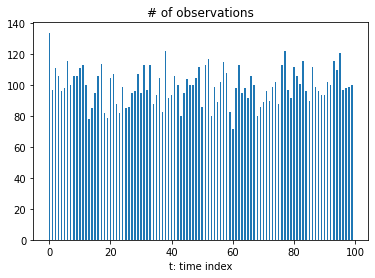

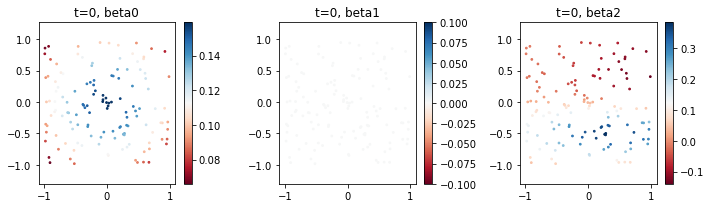

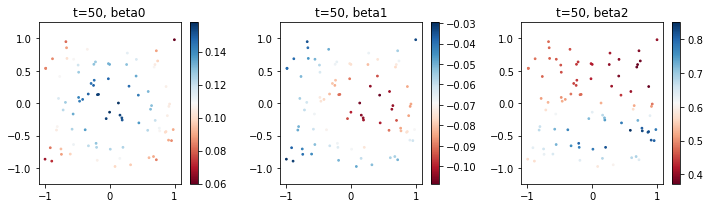

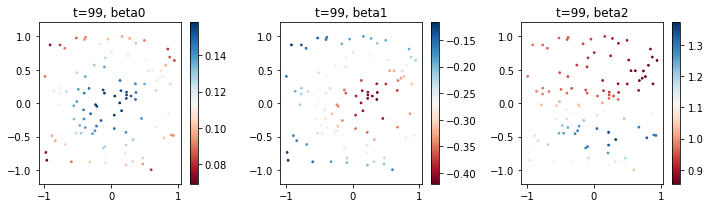

In [2]:
T = 100
D = 3
Ns = np.random.poisson(lam=100, size=T) + 1

plt.bar(range(T), Ns, width=0.5)
plt.title("# of observations")
plt.xlabel("t: time index")
plt.show()

sites = [np.random.uniform(low=-1.0, high=1.0, size=(N, 2)) for N in Ns]


def gen_beta(sites, t):
    N = len(sites)
    betas = np.empty((N, D))

    betas[:, 0] = stats.multivariate_normal(
        mean=[0.0, 0.0], cov=np.diag([1.0, 1.0])
    ).pdf(sites)
    betas[:, 1] = (
        stats.multivariate_normal(mean=[0.5, 0.0], cov=np.diag([0.5, 0.5])).pdf(sites)
        + stats.multivariate_normal(mean=[-0.5, 0.0], cov=np.diag([1.0, 1.0])).pdf(
            sites
        )
    ) * np.sin(t)
    betas[:, 2] = (
        -stats.multivariate_normal(mean=[1.0, 0.0], cov=np.diag([1.0, 1.0])).pdf(sites)
        + stats.multivariate_normal(mean=[0.5, -0.5], cov=np.diag([1.0, 0.1])).pdf(
            sites
        )
        + t / T
    )

    return betas


betas = [gen_beta(sites[t], t) for t in range(T)]

ts = [0, T // 2, T - 1]
for t in ts:
    plt.figure(figsize=(10, 3))
    for d in range(D):
        plt.subplot(1, 3, d + 1)
        plt.axis("equal")
        plt.scatter(sites[t][:, 0], sites[t][:, 1], s=3, cmap="RdBu", c=betas[t][:, d])
        plt.colorbar()
        plt.title(f"t={t}, beta{d}")
    plt.tight_layout()
    plt.show()



generate exogenous variables $X$, and endogenous variables $y$ from coefficents generated above

In [3]:
def gen_data(betas):
    X = []
    y = []
    for t in range(T):
        beta = betas[t]
        N = len(beta)
        X.append(np.random.normal(scale=2, size=(N,D)))
        y.append(np.sum(beta * X[-1], axis=-1) + np.random.normal(scale=0.3, size=(N,)))

    return y, X

y, X = gen_data(betas)

# Model Definition

## Step 1. Eigenvector approxmation

In [4]:
# generate "knots" for approximation
n_knots = 200 # see Murakami and Griffith (2019)
kmeans_rlst = MiniBatchKMeans(n_clusters=n_knots, random_state=234).fit(np.concatenate(sites))
knots = kmeans_rlst.cluster_centers_

# select connectivity class
conn = MoranI.ExpConnectivity

# define approximated eigenvector class
mcapprx = MoranI.MClarge(connectivity=conn, site=np.concatenate(sites), knots=knots)

## Step 2. Model Definition

- `HedonicModels.DynamicHedonic` appends space-time intercept term to the temporally varying coefficient model when argments `sites` and `MClarge` are specified
- `HedonicModels.DynamicHedonicSVC` additionally allows all coeficients vary spatially

In [5]:
model = HedonicModels.DynamicHedonic(Ys=y, Xs=X, sites=sites, MClarge=mcapprx)
model_svc = HedonicModels.DynamicHedonicSVC(Ys=y, Xs=X, sites=sites, MClarge=mcapprx)

## Step 3. Model Fitting

In [6]:
maxiter = 1000

start = time.time()
model.fit(maxiter) # fit with EM algorithm
elpstm = time.time() - start
print(elpstm, "sec. for DynamicESF")

start = time.time()
model_svc.fit(maxiter) # fit with EM algorithm
elpstm = time.time() - start
print(elpstm, "sec. for DynamicESF-SVC")

Q=2962.383:  64%|██████▍   | 639/1000 [01:01<00:34, 10.36it/s] 


61.68585443496704 sec. for DynamicESF


Q=23276.825:  27%|██▋       | 268/1000 [01:56<05:18,  2.30it/s]

116.65780520439148 sec. for DynamicESF-SVC


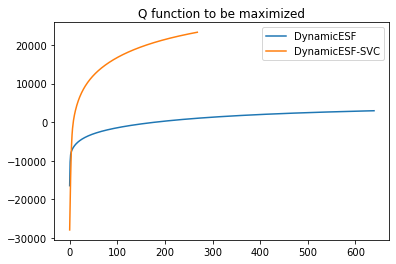

In [7]:
plt.title("Q function to be maximized")
plt.plot(model.DLM.Q, label="DynamicESF")
plt.plot(model_svc.DLM.Q, label="DynamicESF-SVC")
plt.legend()
plt.show()

compare true beta and estimated beta given by `DynamicHedonicSVC`

NameError: name 'i' is not defined

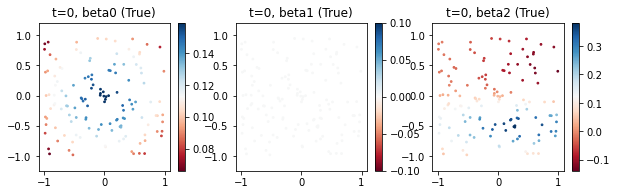

In [8]:
ts = [0, T // 2, T - 1]
for t in ts:
    plt.figure(figsize=(10, 6))
    for d in range(D):
        plt.subplot(2, 3, d + 1)
        plt.axis("equal")
        plt.scatter(sites[t][:, 0], sites[t][:, 1], s=3, cmap="RdBu", c=betas[t][:, d])
        plt.colorbar()
        plt.title(f"t={t}, beta{d} (True)")

    # get spatio-temporal coefficient from estimated model
    beta_est = model_svc.getSpatial(t=t, sites=sites[t])
    for d in range(D):
        plt.subplot(2, 3, (i+1) * 3 + d + 1)
        plt.axis("equal")
        plt.scatter(sites[t][:, 0], sites[t][:, 1], s=3, cmap="RdBu", c=beta_est[:, d])
        plt.colorbar()
        plt.title(f"t={t}, beta{d} (DynamicESF-SVC)")

    plt.tight_layout()
    plt.show()



# Model Predictions

When the timestamps of training data is within `[1, T]`, 

- `model.predict_inner` provides predictions within this interval.
- `model.forecast` provides n step ahead forecast from the end of the interval. E.g. if `n_step = 3`, the forecasts in timestamp `T+3` are provided.

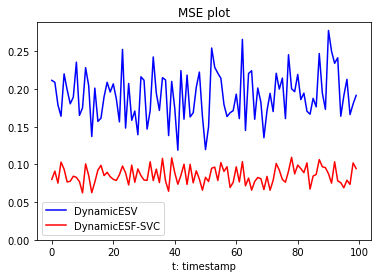

In [ ]:
pred = [model.predict_inner(t, X[t], sites[t]) for t in range(T)]
pred_svc = [model_svc.predict_inner(t, X[t], sites[t]) for t in range(T)]

plt.plot(range(T), [np.mean(np.square(y[t].flatten() - pred[t])) for t in range(T)], c="Blue", label="DynamicESV")
plt.plot(range(T), [np.mean(np.square(y[t].flatten() - pred_svc[t])) for t in range(T)], c="Red", label="DynamicESF-SVC")
plt.legend()
plt.ylim(0, None)
plt.xlabel("t: timestamp")
plt.title("MSE plot")
plt.show()